In [2]:
# Install dependencies
#!pip install pandas numpy nltk vaderSentiment scikit-learn matplotlib ta gensim tensorflow transformers

import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import ta
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch
import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt')
nltk.download('stopwords')


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 50.6 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=b2186b0d0d76dc0e83fd2122b470951a9a53fa1ef309017762d0b39a8fac4e38
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:

# Initialize tools
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
vader_analyzer = SentimentIntensityAnalyzer()

# FinBERT for domain-specific sentiment (Liu et al., 2023)
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
finbert_model = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

# Check for GPU availability to speed up FinBERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
finbert_model.to(device)
print(f"Using device: {device}")

# BERT for contextual embeddings (bert-base-uncased)
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = AutoModel.from_pretrained('bert-base-uncased')
bert_model.to(device)

# Define the 25 tickers
tickers = [
    'AAPL', 'AMD', 'AMZN', 'BA', 'BX', 'COST', 'CRM', 'DIS', 'ENPH', 'F', 'GOOG', 'INTC',
    'KO', 'META', 'MSFT', 'NFLX', 'NIO', 'NOC', 'PG', 'PYPL', 'TSLA', 'TSM', 'VZ', 'XPEV', 'ZS'
]

# Load data
tweets_df = pd.read_csv('stock_tweets.csv')
tweets_df['Date'] = pd.to_datetime(tweets_df['Date']).dt.date
tweets_df = tweets_df[tweets_df['Stock Name'].isin(tickers)].copy()

prices_df = pd.read_csv('stock_yfinance_data.csv')
prices_df['Date'] = pd.to_datetime(prices_df['Date']).dt.date
prices_df = prices_df[prices_df['Stock Name'].isin(tickers)].copy()
prices_df.sort_values(by=['Stock Name', 'Date'], inplace=True)



config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Using device: cuda


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [5]:
# ==============
# 3.1 Text Preprocessing & Representation
# ==============
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+|@\w+|#\w+|[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [ps.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

tweets_df['cleaned_text'] = tweets_df['Tweet'].apply(preprocess_text)

# Sentiment Analysis: VADER (baseline)
tweets_df['vader_score'] = tweets_df['cleaned_text'].apply(
    lambda x: vader_analyzer.polarity_scores(x)['compound']
)

# FinBERT Sentiment with Batch Processing (Liu et al., 2023)
def finbert_sentiment_batch(texts, batch_size=32):
    finbert_scores = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, max_length=512, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = finbert_model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()
        scores = probs[:, 1] - probs[:, 0]  # Positive - Negative
        finbert_scores.extend(scores)
    return finbert_scores

# Apply FinBERT in batches
tweets_df['finbert_score'] = finbert_sentiment_batch(tweets_df['Tweet'].tolist())

# Word2Vec Embeddings (CBOW and Skip-Gram)
tokenized_tweets = tweets_df['cleaned_text'].apply(word_tokenize).tolist()
# CBOW model
w2v_cbow = Word2Vec(tokenized_tweets, vector_size=100, window=5, min_count=1, workers=4, sg=0)
# Skip-Gram model
w2v_sg = Word2Vec(tokenized_tweets, vector_size=100, window=5, min_count=1, workers=4, sg=1)

def get_w2v_embedding(text, model):
    tokens = word_tokenize(text)
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

tweets_df['w2v_cbow_embedding'] = tweets_df['cleaned_text'].apply(lambda x: get_w2v_embedding(x, w2v_cbow))
tweets_df['w2v_sg_embedding'] = tweets_df['cleaned_text'].apply(lambda x: get_w2v_embedding(x, w2v_sg))

# Aggregate daily sentiment with tweet volume (Li & Hu, 2024)
daily_sentiment = tweets_df.groupby(['Date', 'Stock Name']).agg({
    'vader_score': 'mean',
    'finbert_score': 'mean',
    'w2v_cbow_embedding': lambda x: np.mean(np.vstack(x), axis=0),
    'w2v_sg_embedding': lambda x: np.mean(np.vstack(x), axis=0),
    'cleaned_text': ' '.join,
    'Tweet': 'count'  # Tweet volume
}).reset_index()
daily_sentiment.columns = ['Date', 'Stock Name', 'avg_vader_score', 'avg_finbert_score', 'avg_w2v_cbow', 'avg_w2v_sg', 'daily_text', 'tweet_volume']

# TF-IDF Representation (Week 3: Text Classification with Bag-of-Words)
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(daily_sentiment['daily_text'])
print(f"TF-IDF shape: {X_tfidf.shape}")



TF-IDF shape: (5910, 1000)


In [22]:
# ==============
# 3.2 Feature Engineering
# ==============
# Technical Indicators
prices_df['RSI'] = prices_df.groupby('Stock Name')['Close'].transform(
    lambda x: ta.momentum.RSIIndicator(x).rsi()
)
prices_df['MACD'] = prices_df.groupby('Stock Name')['Close'].transform(
    lambda x: ta.trend.MACD(x).macd()
)

def compute_bollinger_bands(group):
    bb = ta.volatility.BollingerBands(group['Close'])
    group['BB_upper'] = bb.bollinger_hband()
    group['BB_middle'] = bb.bollinger_mavg()
    group['BB_lower'] = bb.bollinger_lband()
    return group

prices_df = prices_df.groupby('Stock Name').apply(compute_bollinger_bands).reset_index(drop=True)

# Multi-Horizon Returns (Liapis et al., 2023)
for horizon in [1, 3, 5, 7]:
    prices_df[f'Return_{horizon}d'] = prices_df.groupby('Stock Name')['Close'].pct_change(horizon).shift(-horizon)
    prices_df[f'Price_Movement_{horizon}d'] = np.where(prices_df[f'Return_{horizon}d'] > 0, 1, 0)

# Market Regime Detection
prices_df['Volatility'] = prices_df.groupby('Stock Name')['Close'].pct_change().rolling(window=20).std()
kmeans = KMeans(n_clusters=2, random_state=42)
prices_df['Market_Regime'] = np.nan
valid_idx = prices_df['Volatility'].notna()
prices_df.loc[valid_idx, 'Market_Regime'] = kmeans.fit_predict(
    prices_df.loc[valid_idx, 'Volatility'].values.reshape(-1, 1)
)

# Merge features
data = pd.merge(
    daily_sentiment,
    prices_df[['Date', 'Stock Name', 'Close', 'RSI', 'MACD', 'BB_middle', 'Market_Regime'] +
              [f'Price_Movement_{h}d' for h in [1, 3, 5, 7]] + # Price_Movement columns
              [f'Return_{h}d' for h in [1, 3, 5, 7]]],  # Include Return columns in the merge
    on=['Date', 'Stock Name'],
    how='inner'
).dropna()

# Feature Scaling
scaler = StandardScaler()
features_to_scale = ['avg_vader_score', 'avg_finbert_score', 'tweet_volume', 'RSI', 'MACD', 'BB_middle', 'Market_Regime']
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

# Expand avg_w2v embeddings into separate columns
cbow_df = pd.DataFrame(data['avg_w2v_cbow'].tolist(), index=data.index)
cbow_df = cbow_df.add_prefix('cbow_') # Add prefix to columns of cbow_df
data = pd.concat([data, cbow_df], axis=1)

sg_df = pd.DataFrame(data['avg_w2v_sg'].tolist(), index=data.index)
sg_df = sg_df.add_prefix('sg_') # Add prefix to columns of sg_df
data = pd.concat([data, sg_df], axis=1)

data.drop(['avg_w2v_cbow', 'avg_w2v_sg'], axis=1, inplace=True)


In [26]:
X_finbert_tech = data[['avg_finbert_score', 'tweet_volume', 'RSI', 'MACD', 'BB_middle', 'Market_Regime']]
X_vader_tech = data[['avg_vader_score', 'tweet_volume', 'RSI', 'MACD', 'BB_middle', 'Market_Regime']]
X_sentiment_only = data[['avg_finbert_score', 'tweet_volume']]
X_technicals_only = data[['RSI', 'MACD', 'BB_middle', 'Market_Regime']]
X_w2v_cbow_tech = data[[col for col in data.columns if col.startswith('cbow_')] + ['tweet_volume', 'RSI', 'MACD', 'BB_middle', 'Market_Regime']]
X_w2v_sg_tech = data[[col for col in data.columns if col.startswith('sg_')] + ['tweet_volume', 'RSI', 'MACD', 'BB_middle', 'Market_Regime']]

# Define horizons to predict
horizons = [1, 3, 5, 7]

# Time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Ablation Study Across Horizons
feature_sets = {
    'FinBERT + Technicals': X_finbert_tech,
    'VADER + Technicals': X_vader_tech,
    'Sentiment Only (FinBERT)': X_sentiment_only,
    'Technicals Only': X_technicals_only,
    'Word2Vec CBOW + Technicals': X_w2v_cbow_tech,
    'Word2Vec Skip-Gram + Technicals': X_w2v_sg_tech
}

results = []
for horizon in horizons:
    print(f"\n=== Predictions for {horizon}-Day Horizon ===")
    # Target for the current horizon
    y = data[f'Price_Movement_{horizon}d']

    # Baseline: Majority class prediction
    majority_class = y.mode()[0]
    baseline_pred = [majority_class] * len(y)
    baseline_accuracy = accuracy_score(y, baseline_pred)
    baseline_roc_auc = roc_auc_score(y, baseline_pred)
    print(f"Baseline Accuracy (Majority Class) for {horizon}-Day: {baseline_accuracy:.4f}")
    print(f"Baseline ROC-AUC for {horizon}-Day: {baseline_roc_auc:.4f}")

    for feature_name, X in feature_sets.items():
        print(f"\n--- {feature_name} ---")
        for name, model in models.items():
            accuracies = []
            roc_aucs = []
            precisions = []
            recalls = []
            for train_idx, test_idx in tscv.split(X):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred
                accuracies.append(accuracy_score(y_test, y_pred))
                roc_aucs.append(roc_auc_score(y_test, y_prob))
                precisions.append(precision_score(y_test, y_pred, zero_division=0))
                recalls.append(recall_score(y_test, y_pred, zero_division=0))

            avg_accuracy = np.mean(accuracies)
            avg_roc_auc = np.mean(roc_aucs)
            avg_precision = np.mean(precisions)
            avg_recall = np.mean(recalls)
            print(f"{name} Average Accuracy: {avg_accuracy:.4f}")
            print(f"{name} Average ROC-AUC: {avg_roc_auc:.4f}")
            print(f"{name} Average Precision: {avg_precision:.4f}")
            print(f"{name} Average Recall: {avg_recall:.4f}")
            results.append({
                'Horizon': f'{horizon}-Day',
                'Feature Set': feature_name,
                'Model': name,
                'Accuracy': avg_accuracy,
                'ROC-AUC': avg_roc_auc,
                'Precision': avg_precision,
                'Recall': avg_recall
            })

            if name == 'Random Forest':
                importances = model.feature_importances_
                feature_importance_df = pd.DataFrame({
                    'Feature': X.columns,
                    'Importance': importances
                }).sort_values(by='Importance', ascending=False)
                print(f"Feature Importance for {feature_name}:\n{feature_importance_df}")


=== Predictions for 1-Day Horizon ===
Baseline Accuracy (Majority Class) for 1-Day: 0.5281
Baseline ROC-AUC for 1-Day: 0.5000

--- FinBERT + Technicals ---
Logistic Regression Average Accuracy: 0.5275
Logistic Regression Average ROC-AUC: 0.4909
Logistic Regression Average Precision: 0.3781
Logistic Regression Average Recall: 0.0238
Random Forest Average Accuracy: 0.5104
Random Forest Average ROC-AUC: 0.5080
Random Forest Average Precision: 0.4749
Random Forest Average Recall: 0.4124
Feature Importance for FinBERT + Technicals:
             Feature  Importance
2                RSI    0.217081
4          BB_middle    0.216766
0  avg_finbert_score    0.216405
3               MACD    0.212179
1       tweet_volume    0.118840
5      Market_Regime    0.018729

--- VADER + Technicals ---
Logistic Regression Average Accuracy: 0.5325
Logistic Regression Average ROC-AUC: 0.4937
Logistic Regression Average Precision: 0.5758
Logistic Regression Average Recall: 0.0858
Random Forest Average Accurac

In [32]:
# ==============
# 3.4 LSTM Model (for each horizon)
# ==============
for horizon in horizons:
    print(f"\n=== LSTM Predictions for {horizon}-Day Horizon ===")
    X_lstm = np.array([np.hstack([row['avg_finbert_score'], row['tweet_volume'], row['RSI'], row['MACD'], row['BB_middle'], row['Market_Regime']])
                       for _, row in data.iterrows()])
    X_lstm = X_lstm.reshape((X_lstm.shape[0], 1, X_lstm.shape[1]))
    y_lstm = data[f'Price_Movement_{horizon}d'].values

    lstm_accuracies = []
    lstm_roc_aucs = []
    lstm_precisions = []
    lstm_recalls = []
    for train_idx, test_idx in tscv.split(X_lstm):
        X_train, X_test = X_lstm[train_idx], X_lstm[test_idx]
        y_train, y_test = y_lstm[train_idx], y_lstm[test_idx]
        lstm_model = Sequential([
            LSTM(50, input_shape=(1, X_lstm.shape[2]), return_sequences=False),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        y_pred_prob = lstm_model.predict(X_test, verbose=0).flatten()
        y_pred = (y_pred_prob > 0.5).astype(int)
        lstm_accuracies.append(accuracy_score(y_test, y_pred))
        lstm_roc_aucs.append(roc_auc_score(y_test, y_pred_prob))
        lstm_precisions.append(precision_score(y_test, y_pred, zero_division=0))
        lstm_recalls.append(recall_score(y_test, y_pred, zero_division=0))

    avg_lstm_accuracy = np.mean(lstm_accuracies)
    avg_lstm_roc_auc = np.mean(lstm_roc_aucs)
    avg_lstm_precision = np.mean(lstm_precisions)
    avg_lstm_recall = np.mean(lstm_recalls)
    print(f"LSTM Average Accuracy: {avg_lstm_accuracy:.4f}")
    print(f"LSTM Average ROC-AUC: {avg_lstm_roc_auc:.4f}")
    print(f"LSTM Average Precision: {avg_lstm_precision:.4f}")
    print(f"LSTM Average Recall: {avg_lstm_recall:.4f}")
    results.append({
        'Horizon': f'{horizon}-Day',
        'Feature Set': 'FinBERT + Technicals',
        'Model': 'LSTM',
        'Accuracy': avg_lstm_accuracy,
        'ROC-AUC': avg_lstm_roc_auc,
        'Precision': avg_lstm_precision,
        'Recall': avg_lstm_recall
    })


=== LSTM Predictions for 1-Day Horizon ===
LSTM Average Accuracy: 0.5252
LSTM Average ROC-AUC: 0.4925
LSTM Average Precision: 0.4751
LSTM Average Recall: 0.0457

=== LSTM Predictions for 3-Day Horizon ===
LSTM Average Accuracy: 0.5377
LSTM Average ROC-AUC: 0.4777
LSTM Average Precision: 0.5592
LSTM Average Recall: 0.0936

=== LSTM Predictions for 5-Day Horizon ===
LSTM Average Accuracy: 0.5245
LSTM Average ROC-AUC: 0.5021
LSTM Average Precision: 0.4827
LSTM Average Recall: 0.2743

=== LSTM Predictions for 7-Day Horizon ===
LSTM Average Accuracy: 0.5186
LSTM Average ROC-AUC: 0.4827
LSTM Average Precision: 0.4324
LSTM Average Recall: 0.2014



Summary for 1-Day Horizon:
   Horizon                      Feature Set                Model  Accuracy  \
0    1-Day             FinBERT + Technicals  Logistic Regression  0.527512   
1    1-Day             FinBERT + Technicals        Random Forest  0.510379   
2    1-Day               VADER + Technicals  Logistic Regression  0.532455   
3    1-Day               VADER + Technicals        Random Forest  0.513015   
4    1-Day         Sentiment Only (FinBERT)  Logistic Regression  0.528501   
5    1-Day         Sentiment Only (FinBERT)        Random Forest  0.492586   
6    1-Day                  Technicals Only  Logistic Regression  0.528501   
7    1-Day                  Technicals Only        Random Forest  0.503789   
8    1-Day       Word2Vec CBOW + Technicals  Logistic Regression  0.508072   
9    1-Day       Word2Vec CBOW + Technicals        Random Forest  0.521911   
10   1-Day  Word2Vec Skip-Gram + Technicals  Logistic Regression  0.513015   
11   1-Day  Word2Vec Skip-Gram + Tec

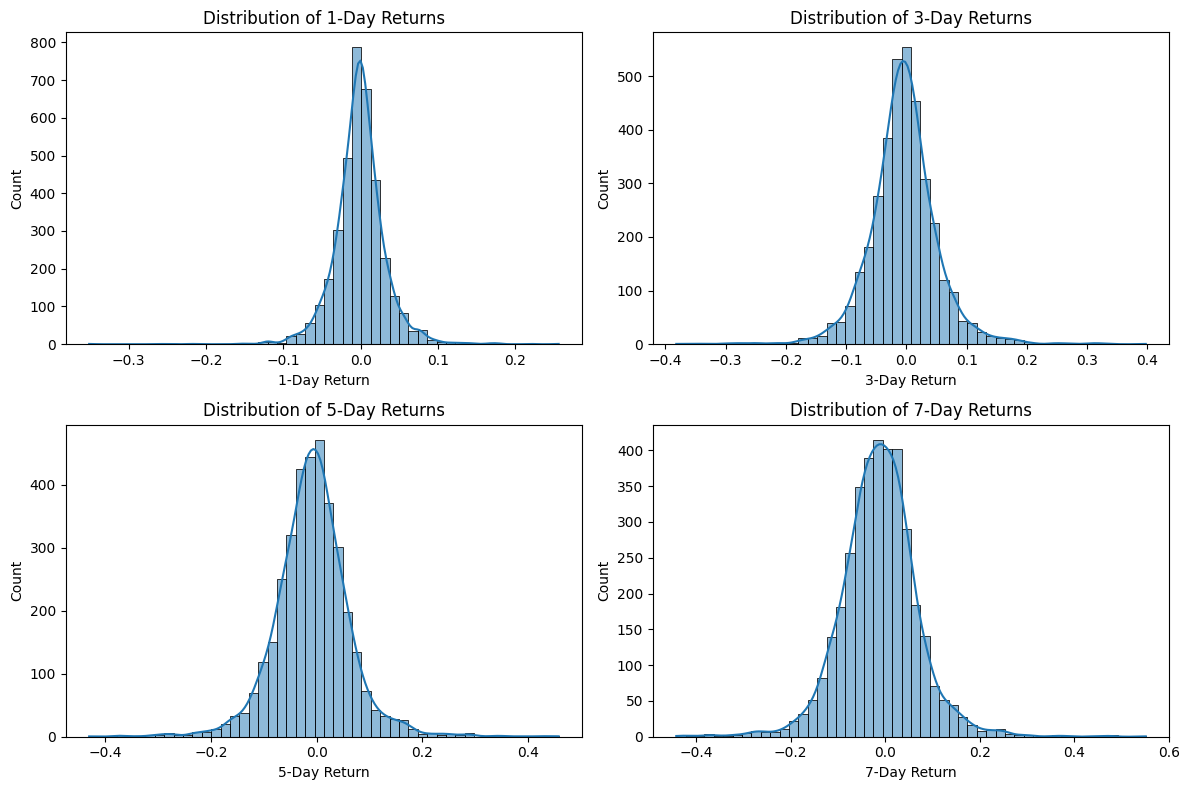

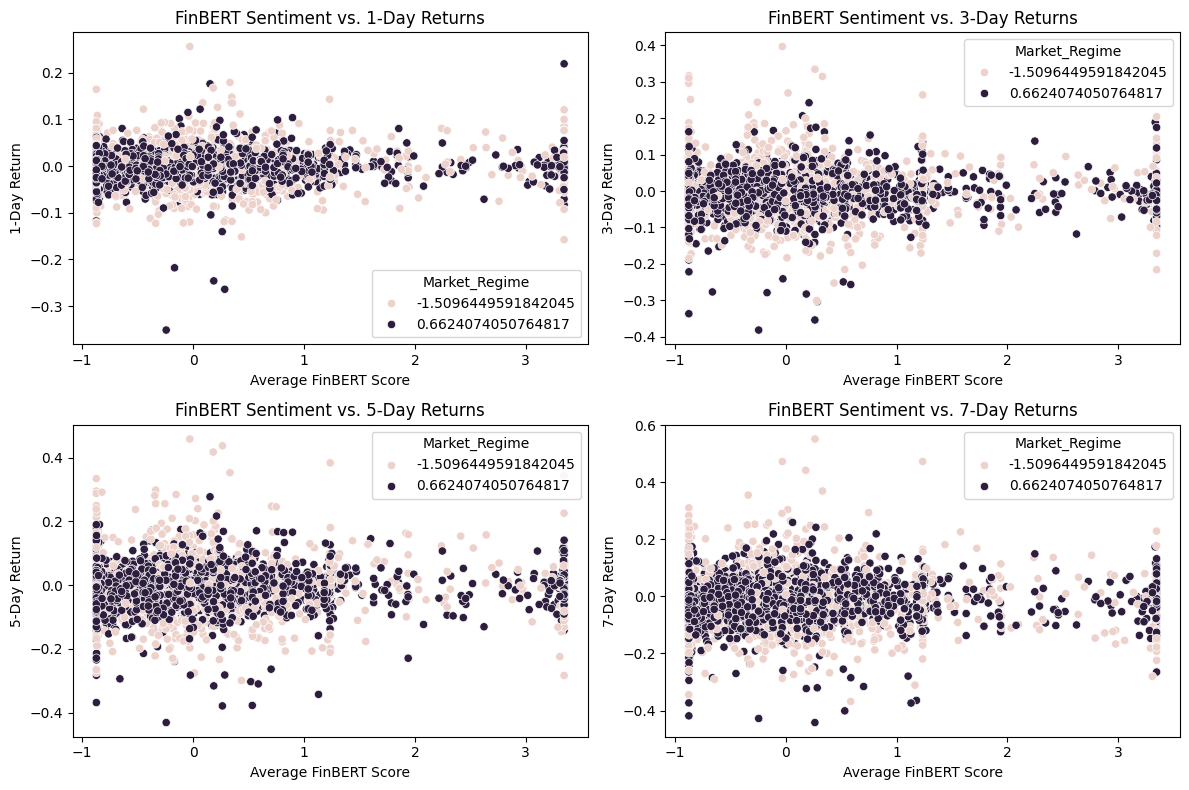


Sentiment Distribution (FinBERT):
count    3.643000e+03
mean    -9.167035e-17
std      1.000137e+00
min     -8.732499e-01
25%     -8.510887e-01
50%     -2.253434e-01
75%      3.321696e-01
max      3.345726e+00
Name: avg_finbert_score, dtype: float64

Sentiment Distribution (VADER):
count    3.643000e+03
mean    -1.248277e-16
std      1.000137e+00
min     -4.586475e+00
25%     -5.983591e-01
50%     -8.059368e-02
75%      5.125238e-01
max      3.074169e+00
Name: avg_vader_score, dtype: float64

Sentiment Statistics:
FinBERT Skewness: 1.7744
VADER Skewness: 0.0171

Correlation Matrix:
                   avg_finbert_score  avg_vader_score  tweet_volume       RSI  \
avg_finbert_score           1.000000         0.194395     -0.028068  0.039917   
avg_vader_score             0.194395         1.000000     -0.088089  0.045093   
tweet_volume               -0.028068        -0.088089      1.000000  0.035627   
RSI                         0.039917         0.045093      0.035627  1.000000   
MACD 

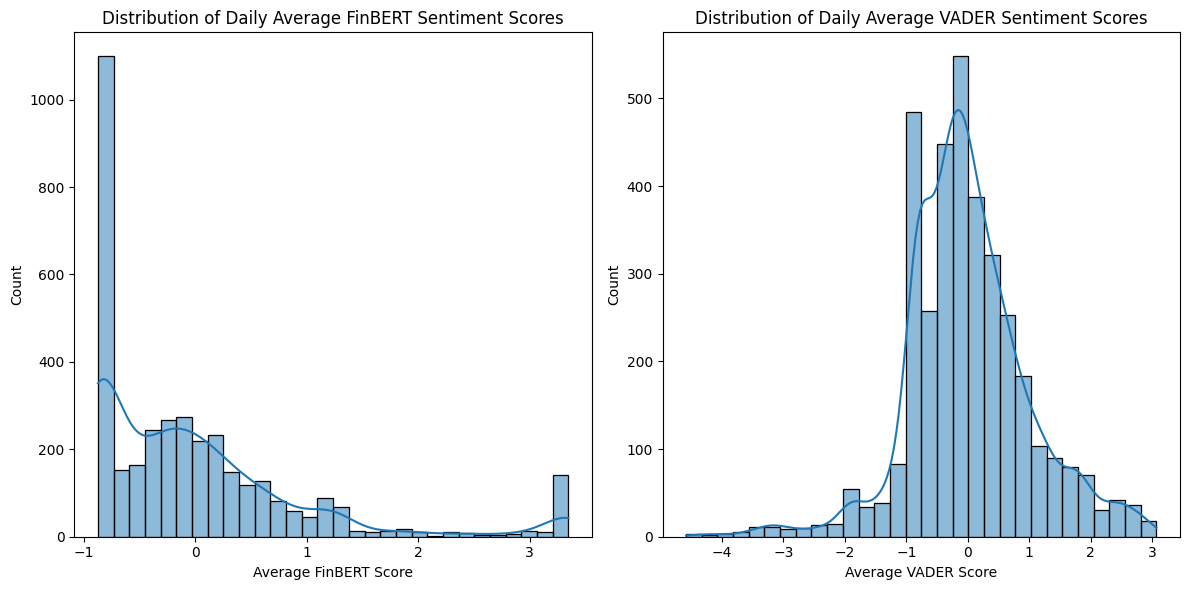

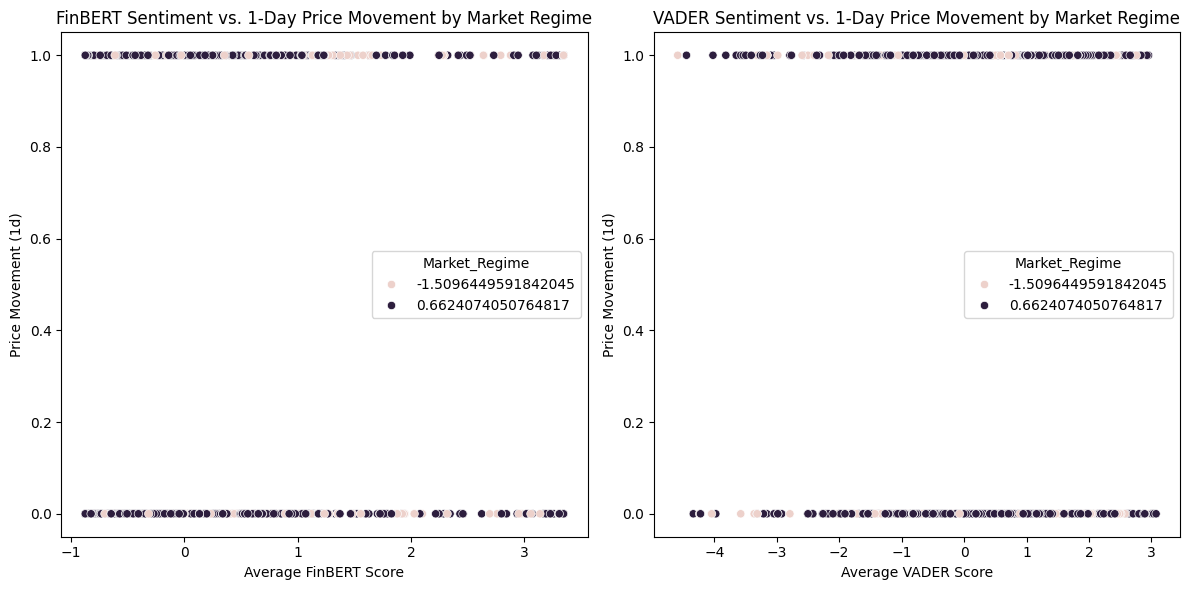

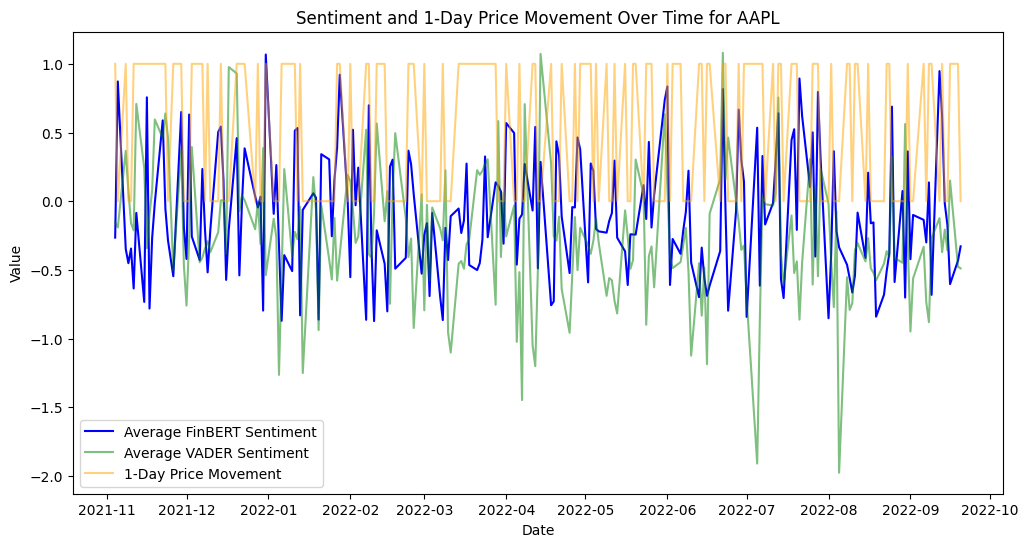

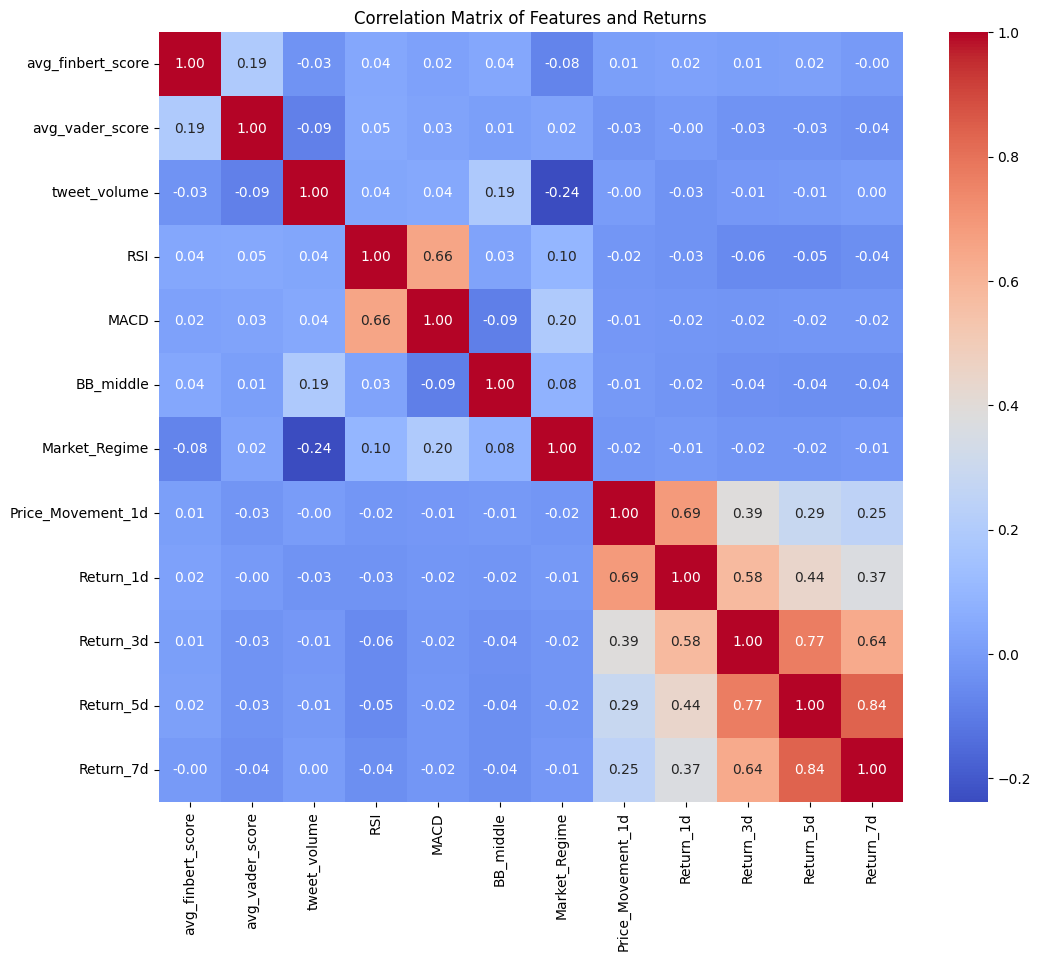

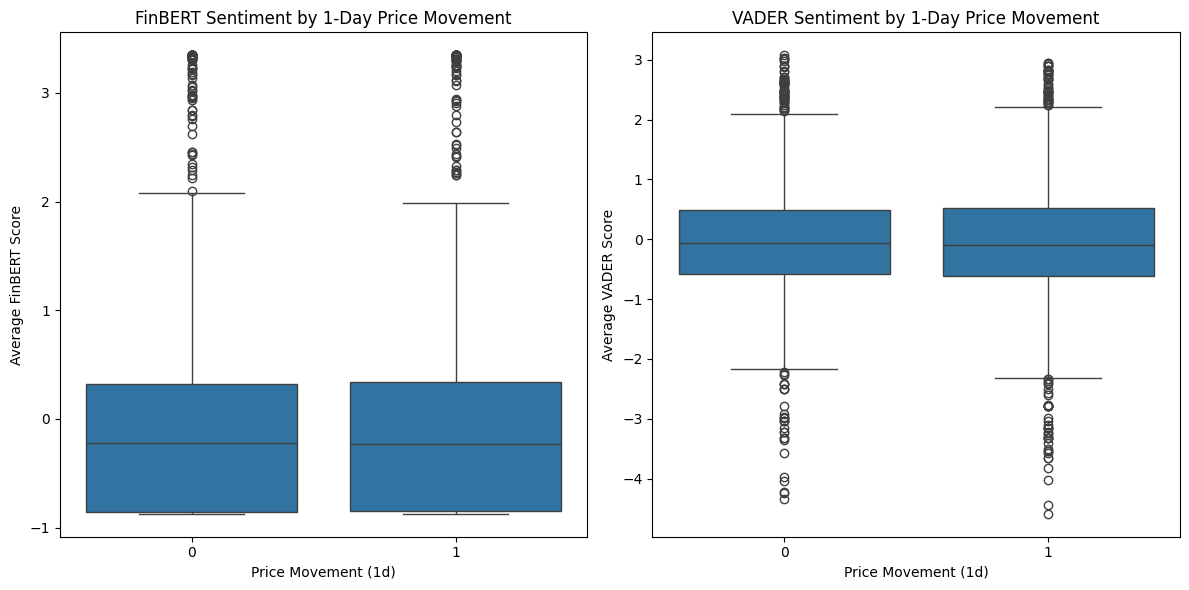

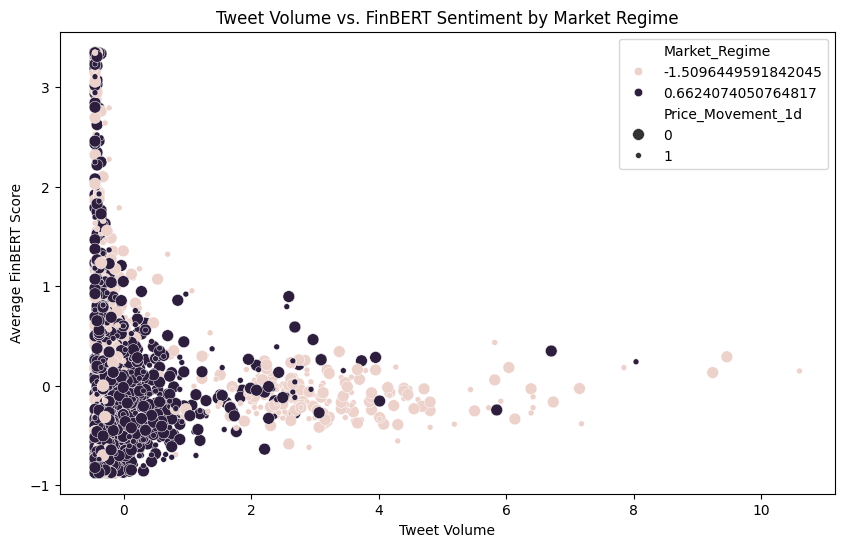

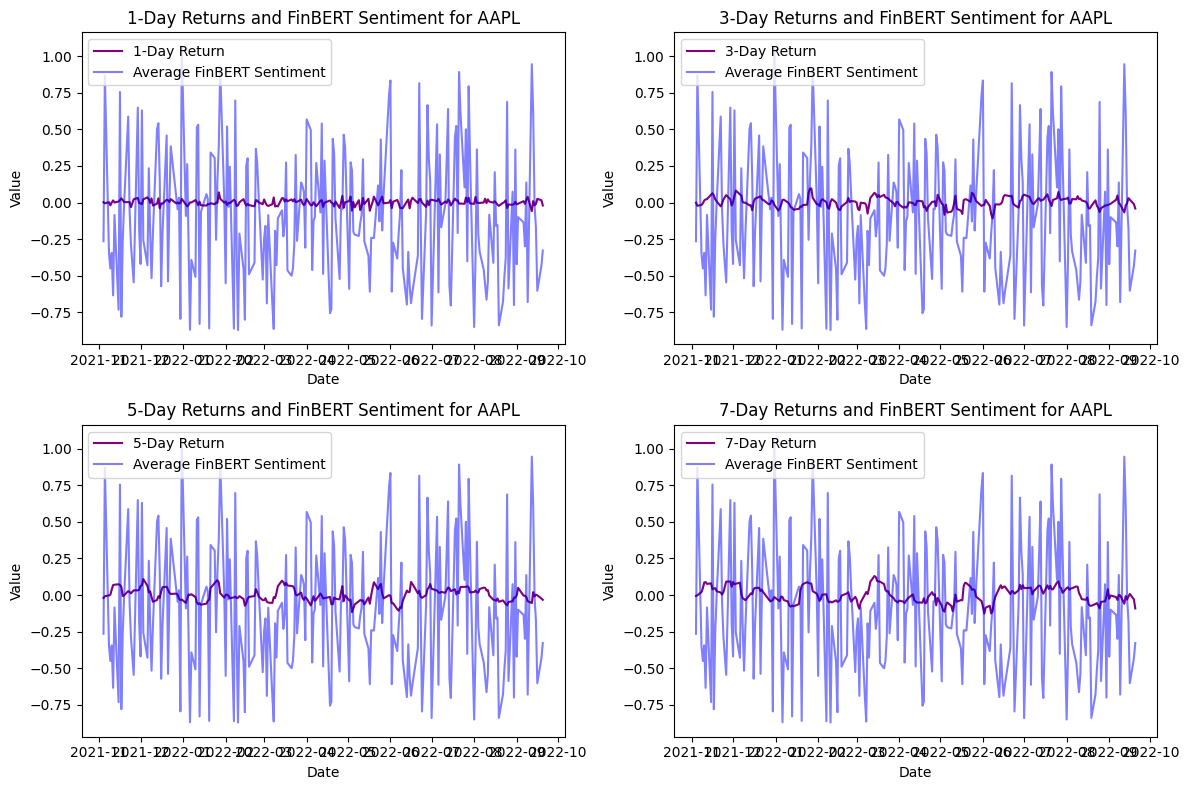

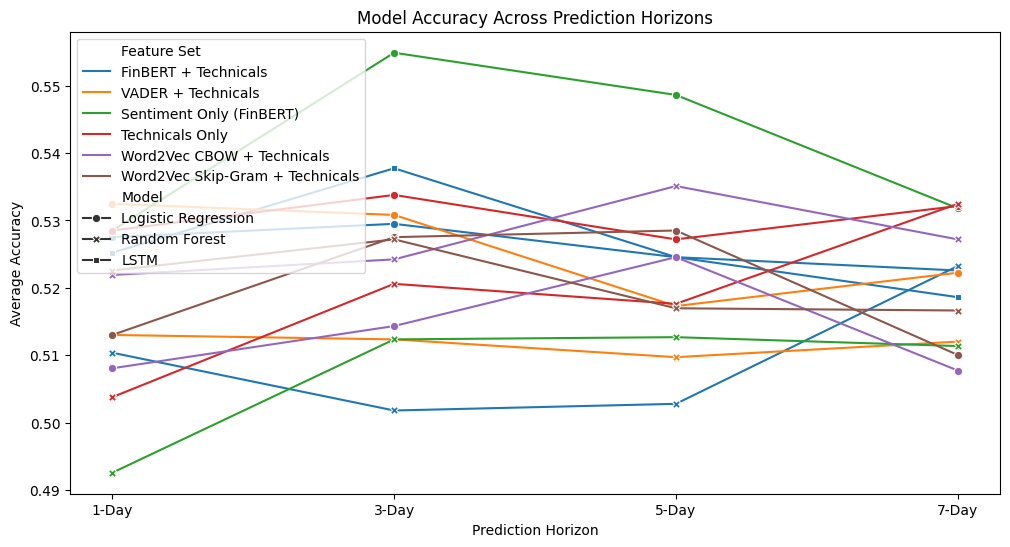

In [35]:
# ==============
# 3.6 Multi-Horizon Predictive Analysis
# ==============
# Results are already computed above for all horizons; summarize them here
results_df = pd.DataFrame(results)
for horizon in horizons:
    print(f"\nSummary for {horizon}-Day Horizon:")
    print(results_df[results_df['Horizon'] == f'{horizon}-Day'])

# Analyze returns distributions
print("\nReturns Statistics:")
for horizon in horizons:
    print(f"\n{horizon}-Day Returns:")
    print(data[f'Return_{horizon}d'].describe())

# Visualize returns distributions
plt.figure(figsize=(12, 8))
for i, horizon in enumerate(horizons, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[f'Return_{horizon}d'], bins=50, kde=True)
    plt.title(f'Distribution of {horizon}-Day Returns')
    plt.xlabel(f'{horizon}-Day Return')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Scatter plot: Sentiment vs. Returns
plt.figure(figsize=(12, 8))
for i, horizon in enumerate(horizons, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x='avg_finbert_score', y=f'Return_{horizon}d', hue='Market_Regime', data=data)
    plt.title(f'FinBERT Sentiment vs. {horizon}-Day Returns')
    plt.xlabel('Average FinBERT Score')
    plt.ylabel(f'{horizon}-Day Return')
plt.tight_layout()
plt.show()

# ==============
# 3.5 & 3.6 Evaluation, Analysis, and Visualizations
# ==============
# Descriptive Statistics
print("\nSentiment Distribution (FinBERT):")
print(data['avg_finbert_score'].describe())
print("\nSentiment Distribution (VADER):")
print(data['avg_vader_score'].describe())

# Additional Statistics
print("\nSentiment Statistics:")
print(f"FinBERT Skewness: {data['avg_finbert_score'].skew():.4f}")
print(f"VADER Skewness: {data['avg_vader_score'].skew():.4f}")

# Correlation Matrix (including returns)
print("\nCorrelation Matrix:")
corr_matrix = data[['avg_finbert_score', 'avg_vader_score', 'tweet_volume', 'RSI', 'MACD', 'BB_middle', 'Market_Regime',
                    'Price_Movement_1d', 'Return_1d', 'Return_3d', 'Return_5d', 'Return_7d']].corr()
print(corr_matrix)

# Visualizations
# 1. Sentiment Distribution Histograms
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['avg_finbert_score'], bins=30, kde=True)
plt.title('Distribution of Daily Average FinBERT Sentiment Scores')
plt.xlabel('Average FinBERT Score')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(data['avg_vader_score'], bins=30, kde=True)
plt.title('Distribution of Daily Average VADER Sentiment Scores')
plt.xlabel('Average VADER Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2. Scatter Plots: Sentiment vs. Price Movement (1-day as example)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='avg_finbert_score', y='Price_Movement_1d', hue='Market_Regime', data=data)
plt.title('FinBERT Sentiment vs. 1-Day Price Movement by Market Regime')
plt.xlabel('Average FinBERT Score')
plt.ylabel('Price Movement (1d)')

plt.subplot(1, 2, 2)
sns.scatterplot(x='avg_vader_score', y='Price_Movement_1d', hue='Market_Regime', data=data)
plt.title('VADER Sentiment vs. 1-Day Price Movement by Market Regime')
plt.xlabel('Average VADER Score')
plt.ylabel('Price Movement (1d)')
plt.tight_layout()
plt.show()

# 3. Time-Series Plot for AAPL (including multi-horizon movements)
stock_data = data[data['Stock Name'] == 'AAPL'].copy()
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.sort_values('Date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(stock_data['Date'], stock_data['avg_finbert_score'], label='Average FinBERT Sentiment', color='blue')
plt.plot(stock_data['Date'], stock_data['avg_vader_score'], label='Average VADER Sentiment', color='green', alpha=0.5)
plt.plot(stock_data['Date'], stock_data['Price_Movement_1d'], label='1-Day Price Movement', color='orange', alpha=0.5)
plt.title('Sentiment and 1-Day Price Movement Over Time for AAPL')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# 4. Correlation Heatmap (including returns)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features and Returns')
plt.show()

# 5. Box Plot: Sentiment by Price Movement (1-day as example)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Price_Movement_1d', y='avg_finbert_score', data=data)
plt.title('FinBERT Sentiment by 1-Day Price Movement')
plt.xlabel('Price Movement (1d)')
plt.ylabel('Average FinBERT Score')

plt.subplot(1, 2, 2)
sns.boxplot(x='Price_Movement_1d', y='avg_vader_score', data=data)
plt.title('VADER Sentiment by 1-Day Price Movement')
plt.xlabel('Price Movement (1d)')
plt.ylabel('Average VADER Score')
plt.tight_layout()
plt.show()

# 6. Tweet Volume vs. Sentiment
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tweet_volume', y='avg_finbert_score', hue='Market_Regime', size='Price_Movement_1d', data=data)
plt.title('Tweet Volume vs. FinBERT Sentiment by Market Regime')
plt.xlabel('Tweet Volume')
plt.ylabel('Average FinBERT Score')
plt.show()

# 7. Returns vs. Sentiment Over Time for AAPL (multi-horizon)
plt.figure(figsize=(12, 8))
for i, horizon in enumerate(horizons, 1):
    plt.subplot(2, 2, i)
    plt.plot(stock_data['Date'], stock_data[f'Return_{horizon}d'], label=f'{horizon}-Day Return', color='purple')
    plt.plot(stock_data['Date'], stock_data['avg_finbert_score'], label='Average FinBERT Sentiment', color='blue', alpha=0.5)
    plt.title(f'{horizon}-Day Returns and FinBERT Sentiment for AAPL')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
plt.tight_layout()
plt.show()

# 8. Model Performance Across Horizons
plt.figure(figsize=(12, 6))
sns.lineplot(x='Horizon', y='Accuracy', hue='Feature Set', style='Model', markers=True, dashes=False, data=results_df)
plt.title('Model Accuracy Across Prediction Horizons')
plt.xlabel('Prediction Horizon')
plt.ylabel('Average Accuracy')
plt.show()

In [34]:
# ==============
# 3.7 BERT Application (on 20% subset, 1-day horizon as example)
# ==============
# Subset 20% of the data
subset_size = int(0.2 * len(tweets_df))
tweets_subset = tweets_df.sample(n=subset_size, random_state=42)

def get_bert_embeddings(texts, batch_size=32):
    bert_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = bert_tokenizer(batch_texts, return_tensors="pt", truncation=True, max_length=512, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token
        bert_embeddings.extend(embeddings)
    return np.array(bert_embeddings)

# Get BERT embeddings for subset
bert_embeddings = get_bert_embeddings(tweets_subset['Tweet'].tolist())
tweets_subset['bert_embedding'] = list(bert_embeddings)

# Aggregate BERT embeddings daily
# Aggregate BERT embeddings daily
daily_bert = tweets_subset.groupby(['Date', 'Stock Name']).agg({
    'bert_embedding': lambda x: np.mean(np.vstack(x), axis=0),
}).reset_index()
# Convert 'bert_embedding' column to a DataFrame and rename columns
bert_embedding_df = pd.DataFrame(daily_bert['bert_embedding'].tolist(), index=daily_bert.index)
bert_embedding_df = bert_embedding_df.add_prefix('bert_') # Add prefix to columns

# Concatenate with daily_bert DataFrame
daily_bert = pd.concat([daily_bert, bert_embedding_df], axis=1)
daily_bert.drop('bert_embedding', axis=1, inplace=True)

# Merge with price data
data_bert = pd.merge(
    daily_bert,
    prices_df[['Date', 'Stock Name', 'Price_Movement_1d']],
    on=['Date', 'Stock Name'],
    how='inner'
).dropna()

# Train a simple model on BERT embeddings
X_bert = data_bert[[col for col in data_bert.columns if col.startswith('bert_')]]
y_bert = data_bert['Price_Movement_1d']
bert_accuracies = []
for train_idx, test_idx in tscv.split(X_bert):
    X_train, X_test = X_bert.iloc[train_idx], X_bert.iloc[test_idx]
    y_train, y_test = y_bert.iloc[train_idx], y_bert.iloc[test_idx]
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    bert_accuracies.append(accuracy_score(y_test, y_pred))
print(f"Average BERT Accuracy (1-Day Horizon): {np.mean(bert_accuracies):.4f}")

Average BERT Accuracy (1-Day Horizon): 0.4874


In [36]:
results_df_rounded = results_df.copy()
results_df_rounded[['Accuracy', 'ROC-AUC', 'Precision', 'Recall']] = results_df_rounded[['Accuracy', 'ROC-AUC', 'Precision', 'Recall']].round(4)

# Sort by Horizon, Feature Set, and Model for better readability
results_df_rounded = results_df_rounded.sort_values(by=['Horizon', 'Feature Set', 'Model'])

# Display the table in Jupyter Notebook (HTML format)
print("Table 1: Model Performance Across Prediction Horizons")
display(results_df_rounded)  # Use display() in Jupyter Notebook for a nicely formatted table

# Export to LaTeX for inclusion in a report
latex_table = results_df_rounded.to_latex(index=False, caption="Model Performance Across Prediction Horizons", label="tab:model_performance")
with open('model_performance_table.tex', 'w') as f:
    f.write(latex_table)
print("LaTeX table saved as 'model_performance_table.tex'")

Table 1: Model Performance Across Prediction Horizons


,Horizon,Feature Set,Model,Accuracy,ROC-AUC,Precision,Recall
48,1-Day,FinBERT + Technicals,LSTM,0.5252,0.4925,0.4751,0.0457
0,1-Day,FinBERT + Technicals,Logistic Regression,0.5275,0.4909,0.3781,0.0238
1,1-Day,FinBERT + Technicals,Random Forest,0.5104,0.5080,0.4749,0.4124
4,1-Day,Sentiment Only (FinBERT),Logistic Regression,0.5285,0.4972,0.0000,0.0000
5,1-Day,Sentiment Only (FinBERT),Random Forest,0.4926,0.4879,0.4583,0.4303
6,1-Day,Technicals Only,Logistic Regression,0.5285,0.4971,0.2028,0.0089
7,1-Day,Technicals Only,Random Forest,0.5038,0.5106,0.4704,0.4601
2,1-Day,VADER + Technicals,Logistic Regression,0.5325,0.4937,0.5758,0.0858
3,1-Day,VADER + Technicals,Random Forest,0.5130,0.5065,0.4796,0.4264
8,1-Day,Word2Vec CBOW + Technicals,Logistic Regression,0.5081,0.5036,0.4727,0.3808


LaTeX table saved as 'model_performance_table.tex'


In [37]:
# Extract returns statistics
returns_stats = data[[f'Return_{h}d' for h in [1, 3, 5, 7]]].describe().T

# Reset index to make 'Horizon' a column
returns_stats = returns_stats.reset_index().rename(columns={'index': 'Horizon'})

# Clean up Horizon column (e.g., 'Return_1d' -> '1-Day')
returns_stats['Horizon'] = returns_stats['Horizon'].str.replace('Return_', '').str.replace('d', '-Day')

# Select relevant columns and round for readability
returns_stats = returns_stats[['Horizon', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']].round(4)

# Rename columns for clarity
returns_stats.columns = ['Horizon', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max']

# Display the table in Jupyter Notebook
print("Table 3: Returns Statistics")
display(returns_stats)

Table 3: Returns Statistics


,Horizon,Mean,Std,Min,25%,50%,75%,Max
0,1-Day,-0.0015,0.0334,-0.3512,-0.0179,-0.0014,0.0148,0.2559
1,3-Day,-0.0048,0.0573,-0.3818,-0.0342,-0.0051,0.0234,0.3972
2,5-Day,-0.0082,0.0718,-0.4309,-0.0476,-0.0077,0.0292,0.4581
3,7-Day,-0.0124,0.0815,-0.4420,-0.0585,-0.0123,0.0328,0.5511
